In [ ]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

## load data

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(75),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
def get_dataloader(transform):
    train_transform, test_transform = transform
    train = torchvision.datasets.CIFAR10(root="/", train = True, download=True, transform = train_transform)
    train, _ = torch.utils.data.random_split(train, [10, 49990])
    test = torchvision.datasets.CIFAR10(root="/", train = False, download=True, transform = test_transform)
    test, val = torch.utils.data.random_split(test, [9000, 1000])
    train_loader = DataLoader(train, batch_size=512, shuffle = True)
    test_loader = DataLoader(test, batch_size = 512, shuffle = False)
    val_loader = DataLoader(val, batch_size = 512, shuffle = True)
    return train_loader, val_loader, test_loader
train_loader, val_loader, test_loader = get_dataloader((train_transform, test_transform))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /cifar-10-python.tar.gz to /
Files already downloaded and verified


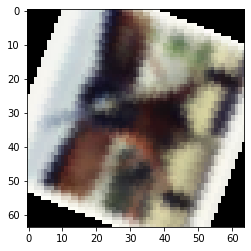

In [ ]:

for x, y in train_loader:
  plt.imshow(x[0].permute(1, 2, 0).numpy())
  break  
  

##  break-down the image in multiple patches and flatten them

In [ ]:
patch_size = 16
f = Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)


(64, 64, 3)


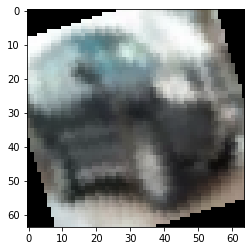

torch.Size([10, 16, 768])


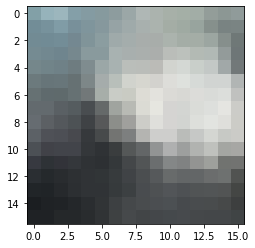

In [ ]:

for x, y in train_loader:
  plt.imshow(x[0].permute(1, 2, 0).numpy())
  print(x[0].permute(1, 2, 0).numpy().shape)
  plt.show()
  out = f(x)
  plt.imshow(out[0][6].reshape(16, 16, 3).numpy())
  print(out.shape)
  break  

In [ ]:
class PatchEmbedding(nn.Module):

    def __init__(self, patch_size = 16, embed_size = 768, in_channel = 3):
        super().__init__()
        self.rearrange = Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
        self.proj = nn.Linear(patch_size * patch_size * in_channel, embed_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.proj(x)
        return x

In [ ]:
m = PatchEmbedding()
x = torch.randn(16, 3, 64, 64)
m(x).shape

torch.Size([16, 16, 768])

In [ ]:
class PatchEmbedding(nn.Module):


    def __init__(self, patch_size = 16, embed_size = 768, in_channel = 3):

        super().__init__()

        self.conv = nn.Conv2d(in_channel, embed_size, kernel_size = patch_size, stride = patch_size)
        self.rearrange = Rearrange('b e (h) (w) -> b (h w) e')

    def forward(self, x):

        x = self.conv(x)
        x = self.rearrange(x)
        return x

In [ ]:
m = PatchEmbedding()
x = torch.randn(16, 3, 64, 64)
m(x).shape

torch.Size([16, 16, 768])

In [ ]:
class PatchEmbedding(nn.Module):


    def __init__(self, patch_size = 16, embed_size = 768, in_channel = 3, img_size = 64):

        super().__init__()

        self.conv = nn.Conv2d(in_channel, embed_size, kernel_size = patch_size, stride = patch_size)
        self.rearrange = Rearrange('b e (h) (w) -> b (h w) e')

        self.cls_token = nn.Parameter(torch.randn(1,1, embed_size)) # bunun random init edilmesini anlayabilirim fakat bu neden learnable parametere
        self.pos = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, embed_size)) # (64 // 16) ** 2 + 1 = 17 
    def forward(self, x):

        x = self.conv(x)
        x = self.rearrange(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=x.shape[0])
        x = torch.cat([x, cls_tokens], dim = 1)
        
        x += self.pos
        return x

In [ ]:
batch_size = 16
in_channel = 3

m = PatchEmbedding()
x = torch.randn(batch_size, in_channel, 64, 64)
m(x).shape

## MultiHeadAttention

In [ ]:
import torch.nn as nn
import torch as th
class MultiHeadAttention(nn.Module):

    def __init__(self, embed_dim = 512, heads = 8, dropout = 0):

        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim
        self.heads = heads
        
        self.head_dim = embed_dim // heads
        assert  embed_dim % heads == 0, ("Embed_dim head sayisi ile tam bolunebilmeli")

        self.key = nn.Linear(embed_dim, embed_dim)
        self.query = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)


        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embed_dim, embed_dim)


    def forward(self, key, value, query, mask = None):

        N = key.shape[0] # batch_size
        T = key.shape[1] # seq_len
        S = query.shape[1] 


        K = self.key(key)
        V = self.value(value)
        Q = self.query(query)

        
        K = K.reshape(N, T, self.heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.reshape(N, T, self.heads, self.head_dim).permute(0, 2, 1, 3)
        Q = Q.reshape(N, S, self.heads, self.head_dim).permute(0, 2, 1, 3)



        energy = th.matmul(Q, K.permute(0, 1, 3, 2))
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -float("inf"))
          # 
        scaling = self.embed_dim ** (1/2)
        attention = self.dropout(th.softmax(energy / scaling, dim = 3)) # -> (N, H, S, T)

        A = th.matmul(attention, V) # (N, H, S, T) x (N, H, T, D) -> (N, H, S, D)

        A = A.permute(0, 2, 1, 3).contiguous() # (N, S, H, D)

        A = A.reshape(N, S, -1) # N , S, embed_dim

        out = self.fc_out(A)

        return out



In [ ]:
model = MultiHeadAttention(embed_dim = 768)
x = torch.randn(16, 16, 3, 64, 64)
m = PatchEmbedding()
x = torch.randn(batch_size, in_channel, 64, 64)
x_in = m(x)
out = model(x_in, x_in, x_in, mask = None)
out.shape

## EncoderBlock

In [ ]:
class EncoderBlock(nn.Module):


    def __init__(self, embed_size = 784, heads = 8, dropout = 0, forward_expansion = 4):

        super().__init__()
        self.attention = MultiHeadAttention(embed_size, heads)
        self.layernorm1 = nn.LayerNorm(embed_size)
        self.layernorm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            
            nn.Linear(embed_size, embed_size * forward_expansion),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_size * forward_expansion, embed_size)
 
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask = None):

        res = x
        x = self.layernorm1(x)
        key, value, query = x, x, x
        out = self.dropout(self.attention(value, key, query, mask))

       
        out = res + out
        res = out
        out = self.dropout(self.feed_forward(self.layernorm2(out)))

        out = res + out
        
        return out
        

        


In [ ]:
model = EncoderBlock(embed_size = 768, heads = 8, dropout=0, forward_expansion=4)
x = torch.randn(1, 3, 64, 64)
m = PatchEmbedding()
out = m(x)
out = model(out)
out.shape

## TransformerEncoder

In [ ]:

class TransformerEncoder(nn.Module):
    def __init__(self, embed_size = 768, heads = 8, dropout = 0, forward_expansion = 4, depth = 12):

        super().__init__()

        self.layers = nn.ModuleList(
          
          [
           EncoderBlock(
               embed_size,
               heads,
               dropout,
               forward_expansion
           )
           for _ in range(depth)
          ]
      )
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x


In [ ]:
model = TransformerEncoder()
result = model(out)
result.shape

torch.Size([10, 16, 768])

In [ ]:
result[:,0,:].shape

torch.Size([10, 768])

In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__()
        
        self.layernorm = nn.LayerNorm(emb_size)
        self.linear = nn.Linear(emb_size, n_classes)
    def forward(self, x):
        
        return self.linear(self.layernorm(x[:,0,:]))


# ViT

In [ ]:

class ViT(nn.Module):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                embed_size: int = 768,
                img_size: int = 64, # cifar-10
                heads = 8,
                depth: int = 12,
                dropout = 0,
                forward_expansion = 4,
                n_classes: int = 10):
       super().__init__()

       self.patch_emb = PatchEmbedding(patch_size, embed_size,in_channels, img_size = img_size)
       self.transformer_encoder = TransformerEncoder(embed_size, heads, dropout, forward_expansion)
       self.classification_head = ClassificationHead(embed_size, n_classes)
    def forward(self, x):

      x_in = self.patch_emb(x)
      features = self.transformer_encoder(x_in)
      out = self.classification_head(features)
      return out

In [ ]:
vit_model = ViT()

In [ ]:
vit_model = ViT(img_size = 224)
x = torch.randn(32, 3, 224, 224)
vit_model(x)

tensor([[ 0.0288, -0.5145, -0.4593, -0.0921,  0.5762,  1.6371,  0.0451,  0.0675,
          1.2428, -0.2795],
        [ 0.4175, -0.7734, -0.7833, -0.2710,  0.6422,  1.3310,  0.1821, -0.3198,
          1.1320, -0.0919],
        [-0.2452, -0.3582, -0.4811, -0.4726, -0.0875,  1.0656, -0.1965, -0.4071,
          0.6196, -0.1750],
        [ 0.0833, -0.6639, -0.4591, -0.1382, -0.2469,  1.1239, -0.0575,  0.2833,
          0.3168,  0.6890],
        [ 0.1036, -0.8059, -0.1719, -0.3922,  0.4672,  1.2677,  0.1955, -0.0646,
          0.6554, -0.0166],
        [-0.4200, -0.2132, -0.4789, -0.2247,  0.1708,  1.3306,  0.0252, -0.4806,
          0.9788, -0.1673],
        [ 0.5317, -0.3353, -0.7516, -0.1762, -0.2542,  1.1752,  0.3105, -0.8307,
          1.1475, -0.5285],
        [ 0.4064, -0.4894, -0.6781, -0.3073,  0.4150,  1.5496,  0.7174, -0.5351,
          0.3013, -0.3573],
        [ 0.8389, -0.5665,  0.0443, -0.6242, -0.1048,  0.9752, -0.0895, -0.4891,
          0.1377,  0.2881],
        [ 0.7486, -

In [ ]:
x = torch.randn(32, 3, 64, 64)
out = vit_model(x)
out.shape

RuntimeError: ignored

## Training

In [ ]:

def train(model, train_loader, val_loader, optimizer, criterion, epoch = 1, display_step = 1, device = "cuda"):

  
  history = {"train_loss" : [], "val_loss" : []}
  i = 0
  loss_train = 0.0
  for e in tqdm(range(epoch)):
    
    
    model.train()
    for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)
      
      scores = model(x)
     
      loss = criterion(scores, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      loss_train += loss.item() / display_step
      i += 1
      if i % display_step == 0:
        print(f"{e}.epoch, {i}.step, train loss = {loss_train}")
        history["val_loss"].append(loss_train)
        loss_train = 0.0
        model.eval()

        with torch.no_grad():
          loss_val = 0.0
          count = 0
          for x_val, y_val in val_loader:
            count += 1
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            scores = model(x_val)
            loss = criterion(scores, y_val)
            loss_val += loss.item()
          history["val_loss"].append(loss_val / count)
          print(f"{e}.epoch, {i}.step val loss = {loss_val / count}")    
        
        model.train()
  return model, history
      

In [ ]:
vit_model = ViT().to("cuda")
optimizer = optim.Adam(vit_model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()


In [ ]:
model, history = train(vit_model, train_loader, val_loader, optimizer, criterion, epoch = 200, device = "cuda")

  0%|          | 0/200 [00:00<?, ?it/s]

0.epoch, 1.step, train loss = 2.563176393508911
0.epoch, 1.step val loss = 6.662927150726318
1.epoch, 2.step, train loss = 2.1373884677886963
1.epoch, 2.step val loss = 6.920828104019165
2.epoch, 3.step, train loss = 2.692232131958008
2.epoch, 3.step val loss = 6.593076944351196
3.epoch, 4.step, train loss = 2.599672794342041
3.epoch, 4.step val loss = 5.832225322723389
4.epoch, 5.step, train loss = 1.6426947116851807
4.epoch, 5.step val loss = 5.744851350784302
5.epoch, 6.step, train loss = 1.3852380514144897
5.epoch, 6.step val loss = 5.926698923110962
6.epoch, 7.step, train loss = 1.4274566173553467
6.epoch, 7.step val loss = 6.200213670730591
7.epoch, 8.step, train loss = 1.5938529968261719
7.epoch, 8.step val loss = 6.279451608657837
8.epoch, 9.step, train loss = 1.603719711303711
8.epoch, 9.step val loss = 6.187959432601929
9.epoch, 10.step, train loss = 1.5150225162506104
9.epoch, 10.step val loss = 6.041566610336304
10.epoch, 11.step, train loss = 1.4254707098007202
10.epoch, 1

In [ ]:
from torchsummary import summary
summary(ViT(), (3, 64, 64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 4, 4]         590,592
         Rearrange-2              [-1, 16, 768]               0
    PatchEmbedding-3              [-1, 17, 768]               0
         LayerNorm-4              [-1, 17, 768]           1,536
            Linear-5              [-1, 17, 768]         590,592
            Linear-6              [-1, 17, 768]         590,592
            Linear-7              [-1, 17, 768]         590,592
           Dropout-8            [-1, 8, 17, 17]               0
            Linear-9              [-1, 17, 768]         590,592
MultiHeadAttention-10              [-1, 17, 768]               0
          Dropout-11              [-1, 17, 768]               0
        LayerNorm-12              [-1, 17, 768]           1,536
           Linear-13             [-1, 17, 3072]       2,362,368
             GELU-14             [-1, 

In [ ]:
def get_acc(model, loader, device = "cuda"):

    model.eval()
    
    num_examples = 0
    correct = 0
    for x, y in tqdm(loader):
        num_examples += x.shape[0]
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
          scores = model(x)
          y_pred = torch.argmax(scores, dim = 1)
          correct += torch.sum(y_pred == y)
    return correct.item() / num_examples

In [ ]:
train_acc = get_acc(vit_model, train_loader, device = "cuda")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(f"training acc : {train_acc}")

training acc : 1.0


In [ ]:
val_acc = get_acc(vit_model, val_loader, device = "cuda")
print(f"val acc : {val_acc}")

  0%|          | 0/2 [00:00<?, ?it/s]

val acc : 0.132


In [ ]:
test_acc = get_acc(vit_model, test_loader, device = "cuda")
print(f"test acc : {test_acc}")

  0%|          | 0/18 [00:00<?, ?it/s]

test acc : 0.1298888888888889
